In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from textwrap import wrap

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'



In [23]:
def load_and_compare(nrc_textblob_path, hybrid_path):
    """Load and prepare data with proper neutral handling"""
    # Load datasets
    nrc_tb = pd.read_csv(nrc_textblob_path)
    hybrid = pd.read_csv(hybrid_path)
    
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'text': nrc_tb['text'],
        'word_count': nrc_tb['text'].apply(lambda x: len(str(x).split())),
        
        # NRCLex metrics (positive/negative only)
        'nrc_pos': nrc_tb['positive'],
        'nrc_neg': nrc_tb['negative'],
        'nrc_net': nrc_tb['positive'] - nrc_tb['negative'],
        
        # TextBlob metrics (with neutral)
        'tb_pos': nrc_tb['positive_sum'],
        'tb_neg': nrc_tb['negative_sum'],
        'tb_neutral': nrc_tb['neutral_sum'],
        'tb_net': nrc_tb['positive_sum'] - nrc_tb['negative_sum'],
        
        # Hybrid metrics (with neutral)
        'hyb_pos': hybrid['positive'],
        'hyb_neg': hybrid['negative'],
        'hyb_neutral': hybrid['neutral'],
        'hyb_net': hybrid['positive'] - hybrid['negative'],
        'hyb_conf': hybrid['avg_score'],
        'sentence_count': hybrid['sentence_count']
    })
    
    # Calculate normalized scores (-1 to 1)
    for method in ['nrc', 'tb', 'hyb']:
        max_val = max(comparison[f'{method}_net'].abs().max(), 1e-10)
        comparison[f'{method}_norm'] = comparison[f'{method}_net'] / max_val
    
    return comparison

comparison_df = load_and_compare(
    'stratifiedSentimentData/stratified_radio_sample_with_sentiment.csv',
    'stratifiedSentimentData/stratified_radio_sample_TextBlob_HYBRID.csv'
)

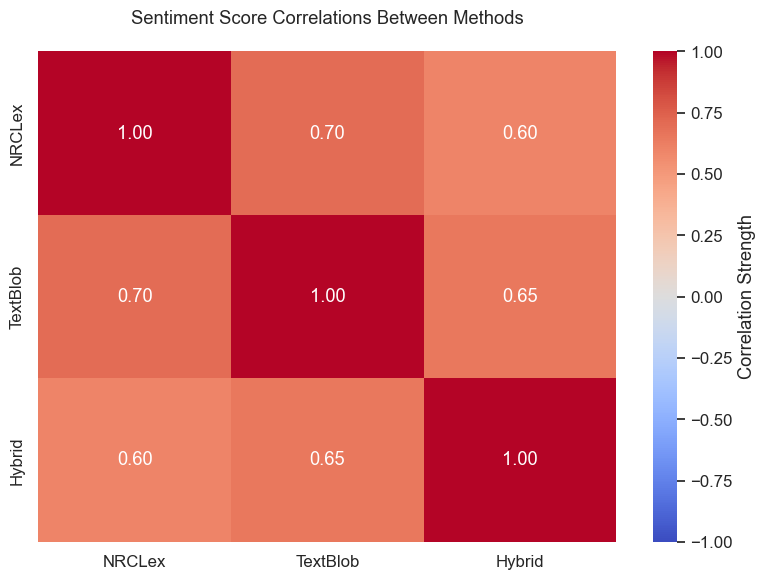

In [40]:
def plot_correlation_matrix(comparison_df):
    """Plot correlation heatmap and print results table"""
    # Calculate correlations and p-values
    methods = ['nrc_net', 'tb_net', 'hyb_net']
    labels = ['NRCLex', 'TextBlob', 'Hybrid']
    
    # Initialize matrices
    corr_matrix = pd.DataFrame(index=labels, columns=labels)
    p_matrix = pd.DataFrame(index=labels, columns=labels)
    
    # Fill matrices
    for i, m1 in enumerate(methods):
        for j, m2 in enumerate(methods):
            r, p = pearsonr(comparison_df[m1].dropna(), comparison_df[m2].dropna())
            corr_matrix.iloc[i,j] = f"{r:.3f}"
            p_matrix.iloc[i,j] = p
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt='.2f', 
               cmap='coolwarm', vmin=-1, vmax=1, 
               cbar_kws={'label': 'Correlation Strength'})
    plt.title("Sentiment Score Correlations Between Methods", pad=20)
    plt.tight_layout()
    plt.show()

    # Return matrices for further analysis
    return corr_matrix, p_matrix

# Usage
corr_results, p_values = plot_correlation_matrix(comparison_df)

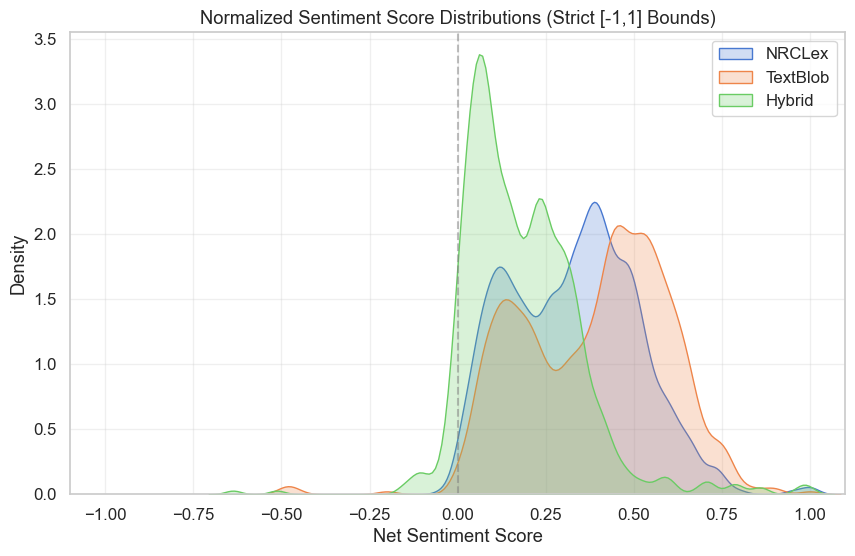

In [33]:
def plot_score_distributions(comparison_df):
    """Plot PROPERLY normalized score distributions"""
    plt.figure(figsize=(10, 6))
    
    # NEW: Symmetric normalization
    def safe_normalize(s):
        max_val = max(s.max(), abs(s.min()))
        return np.where(max_val > 0, s/max_val, s)  # avoid division by zero
    
    comparison_df['nrc_norm'] = safe_normalize(comparison_df['nrc_net'])
    comparison_df['tb_norm'] = safe_normalize(comparison_df['tb_net'])
    comparison_df['hyb_norm'] = safe_normalize(comparison_df['hyb_net'])
    
    # Plot density
    sns.kdeplot(data=comparison_df, x='nrc_norm', label='NRCLex', fill=True, 
                bw_adjust=0.5)  # smoother for long transcripts
    sns.kdeplot(data=comparison_df, x='tb_norm', label='TextBlob', fill=True, 
                bw_adjust=0.5)
    sns.kdeplot(data=comparison_df, x='hyb_norm', label='Hybrid', fill=True,
                bw_adjust=0.5)
    
    plt.title("Normalized Sentiment Score Distributions (Strict [-1,1] Bounds)")
    plt.xlabel("Net Sentiment Score")
    plt.ylabel("Density")
    plt.xlim(-1.1, 1.1)  # Explicit bounds
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Neutral reference
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_score_distributions(comparison_df)

<Figure size 1400x600 with 0 Axes>

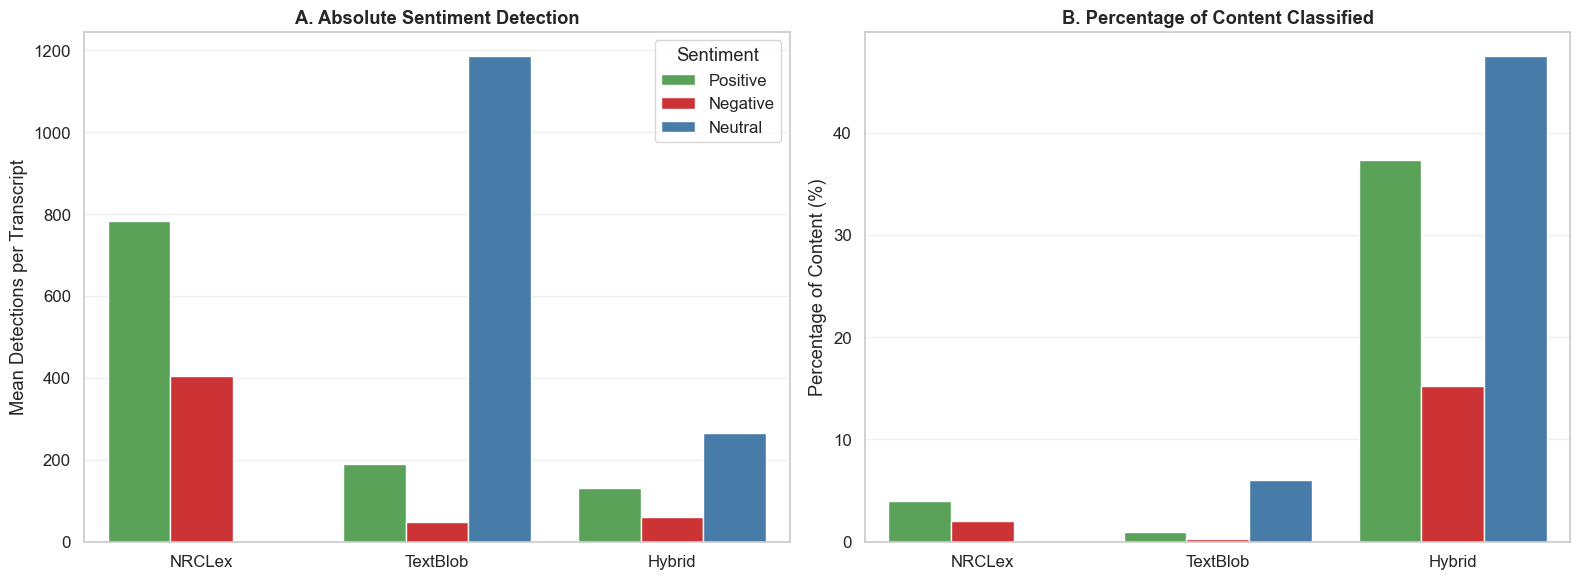

In [29]:
def plot_detection_comparison(comparison_df):
    """Fixed detection comparison with equal-length arrays"""
    plt.figure(figsize=(14, 6))
    
    # Prepare data - NRCLex (2 items)
    nrc_data = {
        'Method': ['NRCLex', 'NRCLex'],
        'Sentiment': ['Positive', 'Negative'],
        'Mean': [
            comparison_df['nrc_pos'].mean(),
            comparison_df['nrc_neg'].mean()
        ],
        'Percentage': [
            (comparison_df['nrc_pos']/comparison_df['word_count']).mean()*100,
            (comparison_df['nrc_neg']/comparison_df['word_count']).mean()*100
        ]
    }
    
    # Prepare data - TextBlob and Hybrid (3 items each)
    other_data = {
        'Method': ['TextBlob']*3 + ['Hybrid']*3,
        'Sentiment': ['Positive', 'Negative', 'Neutral']*2,
        'Mean': [
            comparison_df['tb_pos'].mean(),
            comparison_df['tb_neg'].mean(),
            comparison_df['tb_neutral'].mean(),
            comparison_df['hyb_pos'].mean(),
            comparison_df['hyb_neg'].mean(),
            comparison_df['hyb_neutral'].mean()
        ],
        'Percentage': [
            (comparison_df['tb_pos']/comparison_df['word_count']).mean()*100,
            (comparison_df['tb_neg']/comparison_df['word_count']).mean()*100,
            (comparison_df['tb_neutral']/comparison_df['word_count']).mean()*100,
            (comparison_df['hyb_pos']/comparison_df['sentence_count']).mean()*100,
            (comparison_df['hyb_neg']/comparison_df['sentence_count']).mean()*100,
            (comparison_df['hyb_neutral']/comparison_df['sentence_count']).mean()*100
        ]
    }
    
    # Create separate DataFrames then concatenate
    freq_data = pd.concat([
        pd.DataFrame(nrc_data),
        pd.DataFrame(other_data)
    ])
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot absolute counts
    sns.barplot(data=freq_data, x='Method', y='Mean', hue='Sentiment',
               palette={'Positive': '#4daf4a', 'Negative': '#e41a1c', 'Neutral': '#377eb8'},
               order=['NRCLex', 'TextBlob', 'Hybrid'],
               ax=ax1)
    ax1.set_title("A. Absolute Sentiment Detection", weight='bold')
    ax1.set_ylabel("Mean Detections per Transcript")
    ax1.set_xlabel("")
    ax1.legend(title='Sentiment', frameon=True)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot percentages
    sns.barplot(data=freq_data, x='Method', y='Percentage', hue='Sentiment',
               palette={'Positive': '#4daf4a', 'Negative': '#e41a1c', 'Neutral': '#377eb8'},
               order=['NRCLex', 'TextBlob', 'Hybrid'],
               ax=ax2)
    ax2.set_title("B. Percentage of Content Classified", weight='bold')
    ax2.set_ylabel("Percentage of Content (%)")
    ax2.set_xlabel("")
    ax2.get_legend().remove()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_detection_comparison(comparison_df)

In [39]:
from scipy.stats import kendalltau

def calculate_all_agreement_metrics(comparison_df):
    """Calculate and display multiple agreement metrics between methods"""
    methods = ['nrc_net', 'tb_net', 'hyb_net']
    labels = ['NRCLex', 'TextBlob', 'Hybrid']
    
    # Initialize results tables
    pearson_table = pd.DataFrame(index=labels, columns=labels)
    kendall_table = pd.DataFrame(index=labels, columns=labels)
    sign_agree_table = pd.DataFrame(index=labels, columns=labels)
    sample_size_table = pd.DataFrame(index=labels, columns=labels)
    
    # Calculate all pairwise metrics
    for i, m1 in enumerate(methods):
        for j, m2 in enumerate(methods):
            # Clean data - remove NA pairs
            valid_idx = comparison_df[[m1, m2]].dropna().index
            n = len(valid_idx)
            
            if n > 1:  # Need at least 2 observations
                # Pearson's r
                r, _ = pearsonr(comparison_df.loc[valid_idx, m1], 
                              comparison_df.loc[valid_idx, m2])
                
                # Kendall's Tau
                tau, _ = kendalltau(comparison_df.loc[valid_idx, m1],
                                   comparison_df.loc[valid_idx, m2])
                
                # Sign agreement
                signs_agree = np.sign(comparison_df.loc[valid_idx, m1]) == np.sign(comparison_df.loc[valid_idx, m2])
                sign_agree = signs_agree.mean() * 100
                
                # Store results
                pearson_table.iloc[i,j] = f"{r:.3f}"
                kendall_table.iloc[i,j] = f"{tau:.3f}"
                sign_agree_table.iloc[i,j] = f"{sign_agree:.1f}%"
                sample_size_table.iloc[i,j] = n
            else:
                pearson_table.iloc[i,j] = "NA"
                kendall_table.iloc[i,j] = "NA"
                sign_agree_table.iloc[i,j] = "NA"
                sample_size_table.iloc[i,j] = 0
    
    # Display results
    print("="*80)
    print("Method Comparison Agreement Metrics")
    print("="*80)
    print("\nPearson Correlation Coefficients (r):")
    print(pearson_table)
    
    print("\nKendall's Tau Rank Correlation:")
    print(kendall_table)
    
    print("\nSign Agreement (% of cases with same sign):")
    print(sign_agree_table)
    
    print("\nSample Sizes for Each Comparison:")
    print(sample_size_table)
    print("="*80)
    
    # Return results as DataFrames
    return {
        'pearson': pearson_table,
        'kendall': kendall_table,
        'sign_agree': sign_agree_table,
        'n': sample_size_table
    }

# Usage
metrics = calculate_all_agreement_metrics(comparison_df)

Method Comparison Agreement Metrics

Pearson Correlation Coefficients (r):
         NRCLex TextBlob Hybrid
NRCLex    1.000    0.703  0.597
TextBlob  0.703    1.000  0.650
Hybrid    0.597    0.650  1.000

Kendall's Tau Rank Correlation:
         NRCLex TextBlob Hybrid
NRCLex    1.000    0.639  0.526
TextBlob  0.639    1.000  0.561
Hybrid    0.526    0.561  1.000

Sign Agreement (% of cases with same sign):
          NRCLex TextBlob  Hybrid
NRCLex    100.0%    99.2%   93.6%
TextBlob   99.2%   100.0%   93.8%
Hybrid     93.6%    93.8%  100.0%

Sample Sizes for Each Comparison:
         NRCLex TextBlob Hybrid
NRCLex      624      624    624
TextBlob    624      624    624
Hybrid      624      624    624
